In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [3]:
data = pd.read_csv('netflix_titles.csv')

## Exploratory Analysis

In [4]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [5]:
cont_data = data.select_dtypes('number')
cont_data.describe()

,show_id,release_year
count,6.234000e+03,6234.00000
mean,7.670368e+07,2013.35932
std,1.094296e+07,8.81162
min,2.477470e+05,1925.00000
25%,8.003580e+07,2013.00000
50%,8.016337e+07,2016.00000
75%,8.024489e+07,2018.00000
max,8.123573e+07,2020.00000


In [6]:
cat_data = data.select_dtypes('object')
cat_data.describe()

,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,6234,6234,4265,5664,5758,6223,6224,6234,6234,6234
unique,2,6172,3301,5469,554,1524,14,201,461,6226
top,Movie,Love,"Raúl Campos, Jan Suter",David Attenborough,United States,"January 1, 2020",TV-MA,1 Season,Documentaries,A surly septuagenarian gets another chance at ...
freq,4265,3,18,18,2032,122,2027,1321,299,3


## Data Cleaning
Look for and handle missing data

In [7]:
# Need to clean up nulls, outliers, etc.

# first we'll check for null data
data.isna().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

In [8]:
# Because the nulls seem to be due to input error or an intentional preference not to list information in the director, cast, and country columns, we'll simply fill those values with the value 'Unlisted'
for col in ['director', 'cast', 'country']:
    data[col] = data[col].fillna('Unlisted')

data.isna().sum()

show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      11
release_year     0
rating          10
duration         0
listed_in        0
description      0
dtype: int64

In [9]:
# Since there's no way to recover the true rating for films with no rating, we'll simply fill those nulls with the included 'NR' not-rated value. This is a compromise, but won't affect our overall dataset much with only 10 values being affected.

print(data['rating'].unique())

data['rating'] = data['rating'].fillna('NR')

data.isna().sum()

['TV-PG' 'TV-MA' 'TV-Y7-FV' 'TV-Y7' 'TV-14' 'R' 'TV-Y' 'NR' 'PG-13' 'TV-G'
 'PG' 'G' nan 'UR' 'NC-17']


show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      11
release_year     0
rating           0
duration         0
listed_in        0
description      0
dtype: int64

In [10]:
# As for the data_added, I really can't think of a value that would accurately maintain any important information. We'll simply drop those rows

data.dropna(inplace=True)

# Sum up all nulls in all columns of our data, should be zero now.
data.isna().sum().sum()

0

### Look for and handle outliers

In [11]:
# Locate any outliers with a given threshold (Number of IQRs beyond 1st and 3rd quarter to consider not outliers)
threshold = 1.5

def get_minmax_with_threshold(s, threshold=1.5, range_type='iqr'):
    if range_type == 'iqr':
        q75, q25 = np.percentile(s, [75,25])
        ranged = q75 - q25
    elif range_type == 'std':
        ranged = s.std()

    min_val = q25 - (ranged*threshold)
    max_val = q75 + (ranged*threshold)
    
    return min_val, max_val
    
def get_outliers(s, threshold=1.5, range_type='iqr'):
    min_val, max_val = get_minmax_with_threshold(s, threshold, range_type=range_type)
    return s.loc[(s > max_val) | (s < min_val)]

s = pd.Series([get_outliers(data[col], threshold).count() *100 / len(data[col])
            for col in data.select_dtypes(include='number').columns],
            index=data.select_dtypes(include='number').columns)

print(s)

show_id         46.199582
release_year    10.204082
dtype: float64


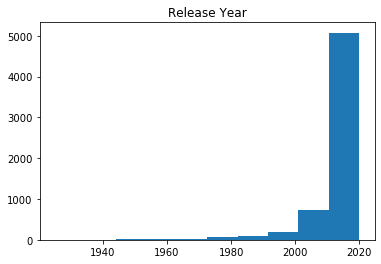

In [12]:
# Since all show_ids are unique and not ordinately meaningful, they will be ignored. We do notice about 10% of release_year values are outliers. To investigate further, we'll check out the distribution of that column

min_val, max_val = get_minmax_with_threshold(data['release_year'], threshold)

plt.hist(data['release_year'])
plt.title('Release Year')
plt.show()

In [13]:
# We notice an exponentially increasing number as the year gets closer to the current year. This makes sense because A: more movies are being produced now and B: it seems logical to assume new movies are more popular. However, for these outliers, we want to know how their age affects their clustering... So we will have to choose a method that is forgiving with outliers.

In [14]:
cont_data = data.select_dtypes('number')
cat_data = data.select_dtypes('object')

NameError: name 'movies' is not defined

## Feature Selection

In [15]:
# Drop the show_id, as it won't be beneficial to the model
cont_data.drop('show_id', axis=1, inplace=True)

In [16]:
# View an organized output of the number of unique values in each categorical column
cat_data.nunique().sort_values()

type              2
rating           14
duration        201
listed_in       461
country         554
date_added     1524
director       3301
cast           5469
title          6172
description    6226
dtype: int64

In [17]:
# Identify drop columns that are pointless to encode (This would be a little more interesting using NLP)
# Also include columns that can be manually turned into quantitative data
drop_cols = ['title', 'description', 'date_added', 'duration']

# Identify columns that won't be difficult to one-hot encode
easy_encode_cols = []

# Identify columns that will be difficult to encode because the value includes multiple values separated by commas. 
diff_encode_cols = []

for col in cat_data.drop(drop_cols, axis=1).columns:
    if cat_data[col].str.count(',').max() == 0:
        easy_encode_cols.append(col)
    else:
        diff_encode_cols.append(col)

print('Easy to encode columns:', easy_encode_cols)
print('Difficult to encode columns:', diff_encode_cols)

Easy to encode columns: ['type', 'rating']
Difficult to encode columns: ['director', 'cast', 'country', 'listed_in']


### Handle difficult to encode columns
One true value (like the actor 'Samuel L. Jackson') could occur in multiple rows with different casts. We want to be able to say that all films with Samuel L. Jackson are related, even if the rest of the cast is different.

We'll use the `.str.get_dummies()` method, using `', '` as a separator. This will create a one-hot-encoded variable for each unique value within the string of comma-combined values for each row. This may take a while to run.

While this will significantly impact our dimensionality, it will actually increase our number of columns needed to encode our data less than if we simply one-hot-encoded it as-is, yet we will retain more accurate information.

In [18]:
# Initialize a dictionary that will hold our string dummy dataframes
diff_encoded_dfs = {}

# Fill the dict with dummy encoded dataframes representing each column. 
for col in diff_encode_cols:
    diff_encoded_dfs[col] = cat_data[col].str.get_dummies(sep=', ')
    print(col)
    print(diff_encoded_dfs[col].shape)
    print(diff_encoded_dfs[col].columns)
    print('----------------------------------------------------')

########## TRY dropping the actors

######### TRY USING "POPULAR ACTORS" - ordered by number of occurrences - avg?

director
(6234, 3655)
Index(['A. L. Vijay', 'A. Salaam', 'A.R. Murugadoss', 'Aadish Keluskar',
       'Aamir Bashir', 'Aamir Khan', 'Aanand Rai', 'Aaron Burns',
       'Aaron Hancox', 'Aaron Hann',
       ...
       'Àlex Pastor', 'Álex de la Iglesia', 'Álvaro Brechner',
       'Álvaro Longoria', 'Çagan Irmak', 'Éric Warin', 'Ísold Uggadóttir',
       'Óskar Thór Axelsson', 'Ömer Faruk Sorak', 'Şenol Sönmez'],
      dtype='object', length=3655)
----------------------------------------------------
cast
(6234, 27405)
Index([' Jr.', '2 Chainz', '4Minute', '50 Cent', 'A Boogie Wit tha Hoodie',
       'A-ra Go', 'A. Murat Özgen', 'A.C. Peterson', 'A.D. Miles', 'A.J. Cook',
       ...
       'Şafak Başkaya', 'Şafak Pekdemir', 'Şafak Sezer', 'Şebnem Bozoklu',
       'Şenay Bozoklar', 'Şenay Gürler', 'Şerif Sezer', 'Şinasi Yurtsever',
       'Şükran Ovalı', 'Şükrü Özyıldız'],
      dtype='object', length=27405)
----------------------------------------------------
country
(6234, 113)
Index(['Af

In [19]:
# I noticed one anomoly ' Jr.' in the cast. This is the only thing that started with a space, so I think I can assume it was an error.

# Print number of times ' Jr.' ocurred
print(diff_encoded_dfs['cast'][' Jr.'].sum())

# Drop the Jr. column
diff_encoded_dfs['cast'].drop(' Jr.', axis=1, inplace=True)

1


### Encode easy categorical columns
For the easier columns, we'll simply one-hot encode them

In [20]:
# Get dummies for all simple qualitative column categories

################################ For rating -> ordinally encode it 

easy_encoded_df = pd.get_dummies(cat_data[easy_encode_cols], drop_first=True)
print(easy_encode_cols)
print(easy_encoded_df.shape)
print(easy_encoded_df.columns)

['type', 'rating']
(6234, 14)
Index(['type_TV Show', 'rating_NC-17', 'rating_NR', 'rating_PG',
       'rating_PG-13', 'rating_R', 'rating_TV-14', 'rating_TV-G',
       'rating_TV-MA', 'rating_TV-PG', 'rating_TV-Y', 'rating_TV-Y7',
       'rating_TV-Y7-FV', 'rating_UR'],
      dtype='object')


### Concert some columns to numeric
#### Duration

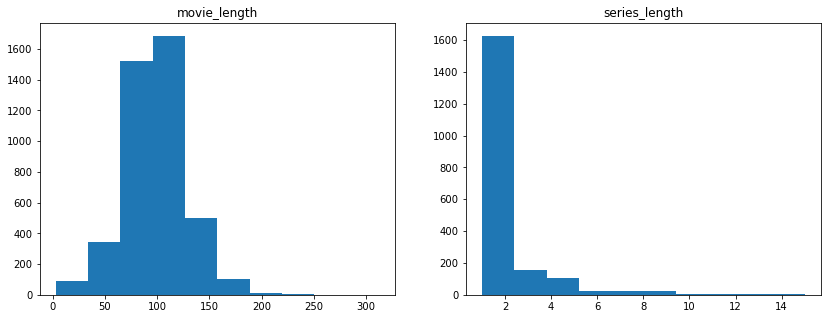

In [21]:
# Convert the movie and series lengths to integers separately.
movie_length_mins = cat_data.loc[cat_data['type'] == 'Movie']['duration'].str.strip(' min').astype('int64')
movie_length_mins.name = 'movie_length'

series_length_seasons = cat_data.loc[cat_data['type'] == 'TV Show']['duration'].str.strip(' Season').astype('int64')
series_length_seasons.name = 'series_length'

# For each of the series, plot a distribution
plt.figure(figsize=(14,5))
for i, S in enumerate([movie_length_mins, series_length_seasons], 1):
    plt.subplot(1,2,i)
    plt.title(S.name)
    plt.hist(S)
plt.show()

########################## Cluster within each separate category (movie/tv) opr standardize across

In [22]:
# Combine these two together so that when one column has a value, the other is 0. This will also maintain the index of our other dataframes
combined_lengths = pd.concat([movie_length_mins, series_length_seasons], axis=1)
combined_lengths.fillna(0, inplace=True)
print(combined_lengths.head())

movie_length  series_length
0          90.0            0.0
1          94.0            0.0
2           0.0            1.0
3           0.0            1.0
4          99.0            0.0


In [23]:
# The above function created two features that represent the data in another feature: 'type'. 
# To avoid perfect multicollinearity with this feature and reduce our dimensions a bit, we'll remove that particular feature from the dummy dataframe
type_drop_cols = easy_encoded_df.filter(regex='type').columns
easy_encoded_df.drop(type_drop_cols, axis=1, inplace=True)

#### Date Added

In [24]:
# convert date added to datetime object and retain the year, since we have release year stored. 
added_year = pd.to_datetime(cat_data['date_added']).dt.year
# added_year = added_year.astype('int64') ############################# ADDD THIS BACK IN WHEN YOU FINISH NULL HANDLING
added_year.name = 'added_year'
print(added_year.shape)
added_year.isna().sum()

(6234,)


11

### Combine quantitative and qualitative features together

In [25]:
# combine the given continuous variables with the new lenghts and added_year features
quantitative_data = pd.concat([cont_data, combined_lengths], axis=1)
quantitative_data = pd.concat([quantitative_data, added_year], axis=1)
print('quantitative data')
print(quantitative_data.shape)
print(quantitative_data.columns)
quantitative_data.head()

quantitative data
(6234, 4)
Index(['release_year', 'movie_length', 'series_length', 'added_year'], dtype='object')


,release_year,movie_length,series_length,added_year
0,2019,90.0,0.0,2019.0
1,2016,94.0,0.0,2016.0
2,2013,0.0,1.0,2018.0
3,2016,0.0,1.0,2018.0
4,2017,99.0,0.0,2017.0


In [26]:
# Combine all encoded categorical dfs
qualitative_data = easy_encoded_df.copy()
for key in diff_encoded_dfs:
    qualitative_data = pd.concat([qualitative_data, diff_encoded_dfs[key]], axis=1)
print('qualitative data')
print(qualitative_data.shape)
print(qualitative_data.columns)
qualitative_data.head()

qualitative data
(6234, 31227)
Index(['rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y',
       ...
       'TV Action & Adventure', 'TV Comedies', 'TV Dramas', 'TV Horror',
       'TV Mysteries', 'TV Sci-Fi & Fantasy', 'TV Shows', 'TV Thrillers',
       'Teen TV Shows', 'Thrillers'],
      dtype='object', length=31227)


,rating_NC-17,rating_NR,rating_PG,rating_PG-13,rating_R,rating_TV-14,rating_TV-G,rating_TV-MA,rating_TV-PG,rating_TV-Y,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Scale the quantitative features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_quant_data = scaler.fit_transform(quantitative_data)
quantitative_data_std = pd.DataFrame(scaled_quant_data, columns=quantitative_data.columns, index=quantitative_data.index)
quantitative_data_std

,release_year,movie_length,series_length,added_year
0,0.640192,0.430334,-0.456224,0.843917
1,0.299706,0.507871,-0.456224,-1.646218
2,-0.040781,-1.314260,0.355449,0.013872
3,0.299706,-1.314260,0.355449,0.013872
4,0.413201,0.604793,-0.456224,-0.816173
...,...,...,...,...
6229,0.186210,-1.314260,10.095523,NaN
6230,0.299706,-1.314260,2.790467,NaN
6231,0.299706,-0.151197,-0.456224,NaN
6232,-0.040781,-1.314260,1.167121,NaN


In [28]:
# Concatenate the qualitative and quantitative features together
X = pd.concat([quantitative_data_std, qualitative_data], axis=1)
X.dropna(inplace=True)
X

,release_year,movie_length,series_length,added_year,rating_NC-17,rating_NR,rating_PG,rating_PG-13,rating_R,rating_TV-14,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,0.640192,0.430334,-0.456224,0.843917,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.299706,0.507871,-0.456224,-1.646218,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.040781,-1.314260,0.355449,0.013872,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.299706,-1.314260,0.355449,0.013872,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.413201,0.604793,-0.456224,-0.816173,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6218,0.413201,-1.314260,1.167121,0.843917,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6219,0.640192,-1.314260,1.167121,0.843917,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6220,-0.154277,-1.314260,1.167121,-1.646218,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6221,0.299706,-1.314260,1.167121,-1.646218,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


This feature set has nearly 5X as many dimensions as it does data. This means we'll need to do some serious dimension reduction. Because our data is very highly dimensional and seems unlikely to be linearly related, we're going to start by using UMAP to reduce our data.

I don't know if I would rather have this done on the mixed set, or if I want to do some DimRed on just the categorical variables (maybe even on each type of categorical variables)

In [29]:
import umap

actor_occurences = diff_encoded_dfs['cast'].sum().sort_values(ascending=False)
actor_occurences.head(50)

Anupam Kher            33
Shah Rukh Khan         30
Naseeruddin Shah       27
Om Puri                27
Akshay Kumar           26
Yuki Kaji              26
Paresh Rawal           25
Takahiro Sakurai       25
Amitabh Bachchan       24
Boman Irani            23
John Cleese            22
Ashleigh Ball          22
Andrea Libman          22
Kareena Kapoor         19
Daisuke Ono            18
Kay Kay Menon          18
Tara Strong            18
Vincent Tong           18
Gulshan Grover         18
Erin Fitzgerald        18
Fred Tatasciore        18
David Attenborough     18
Laura Bailey           17
Kate Higgins           17
Nicolas Cage           17
Mamoru Miyano          16
Robb Wells             16
Debi Derryberry        16
Jackie Shroff          16
Eric Idle              15
Saif Ali Khan          15
Michael Palin          15
Rajpal Yadav           15
Danny Trejo            15
Asrani                 15
John Paul Tremblay     15
Molly Shannon          15
Samuel L. Jackson      15
Ajay Devgn  

In [30]:
umap_results = umap.UMAP(n_neighbors = 5, min_dist =.3, metric='correlation').fit_transform(X)

In [31]:
umap_results

array([[ 4.581191  ,  2.534883  ],
       [ 8.240597  ,  2.3988662 ],
       [-2.1656985 ,  1.3632617 ],
       ...,
       [-1.214547  ,  0.47995502],
       [-4.782255  , -1.515494  ],
       [-2.460069  , -1.2267163 ]], dtype=float32)

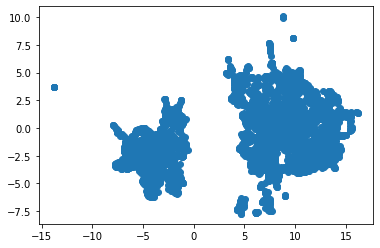

In [32]:
plt.scatter(umap_results[:,0], umap_results[:,1])

In [33]:
# Check for normality (See if your model needs a normal distribution)

from sklearn.cluster import KMeans

k = 4
k_means = KMeans(n_clusters=k)
k_means.fit(X)
predictions = k_means.predict(X)

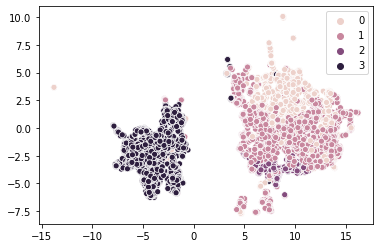

In [34]:
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
sns.scatterplot(umap_results[:,0], umap_results[:,1], hue=pd.Series(predictions))

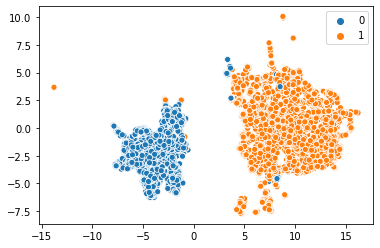

In [35]:
from sklearn.cluster import KMeans

k = 2
k_means = KMeans(n_clusters=k)
k_means.fit(X)
predictions = k_means.predict(X)
sns.scatterplot(umap_results[:,0], umap_results[:,1], hue=pd.Series(predictions))

In [36]:
######################### Scrape IMDB and scrape for actor experience (what kind of resume do they have -> could be indicative of budget)

################### Umap -> DBSCAN

################ possibly join movies and series post-cluster

In [37]:
data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unlisted,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,Unlisted,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,Unlisted,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6218,80162994,TV Show,Talking Tom and Friends,Unlisted,"Colin Hanks, Tom Kenny, James Adomian, Lisa Sc...","Cyprus, Austria, Thailand","April 10, 2019",2017,TV-G,2 Seasons,"Kids' TV, TV Comedies",Full of funny one-liners and always ready for ...
6219,80186475,TV Show,Pokémon the Series,Unlisted,"Sarah Natochenny, Laurie Hymes, Jessica Paquet...",Japan,"April 1, 2019",2019,TV-Y7-FV,2 Seasons,"Anime Series, Kids' TV",Ash and his Pikachu travel to the Alola region...
6220,70272742,TV Show,Justin Time,Unlisted,"Gage Munroe, Scott McCord, Jenna Warren",Canada,"April 1, 2016",2012,TV-Y,2 Seasons,Kids' TV,"In Justin's dreams, he and his imaginary frien..."
6221,80067942,TV Show,Terrace House: Boys & Girls in the City,Unlisted,"You, Reina Triendl, Ryota Yamasato, Yoshimi To...",Japan,"April 1, 2016",2016,TV-14,2 Seasons,"International TV Shows, Reality TV",A new set of six men and women start their liv...


In [38]:
movies = data.loc[data.type == 'Movie']
movies

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unlisted,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
6,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f..."
7,80164077,Movie,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,"September 8, 2017",2017,TV-MA,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...
...,...,...,...,...,...,...,...,...,...,...,...,...
5575,80093107,Movie,Toro,Kike Maíllo,"Mario Casas, Luis Tosar, José Sacristán, Claud...",Spain,"April 1, 2017",2016,NR,106 min,"Dramas, International Movies, Thrillers",Ex-con Toro's brother and former partner in cr...
5577,80085438,Movie,Frank and Cindy,G.J. Echternkamp,Unlisted,United States,"April 1, 2016",2007,TV-MA,70 min,Documentaries,Frank was a rising pop star when he married Ci...
5578,80085439,Movie,Frank and Cindy,G.J. Echternkamp,"Rene Russo, Oliver Platt, Johnny Simmons, Jane...",United States,"April 1, 2016",2015,R,102 min,"Comedies, Dramas, Independent Movies",A student filmmaker vengefully turns his camer...
5579,80011846,Movie,Iverson,Zatella Beatty,Allen Iverson,United States,"April 1, 2016",2014,NR,88 min,"Documentaries, Sports Movies",This unfiltered documentary follows the rocky ...
